<p><a href="https://www.asu.edu.eg/"><img align="right" src="https://ums.asu.edu.eg/images/logo.png" width="100" /></a></p>
<div align=left>
<h1>
  Spam Detection
</h1>
    <h6>
        Data Analytics Task
    </h6>
</div>
<br>
<br>

#### All libraries that we will need and use through the notebook

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer,WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import joblib
import pickle
%matplotlib inline

#### Reading the dataset

In [2]:
df = pd.read_csv('data_spam.csv', encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


# Data Cleaning

In [3]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)

In [4]:
df = df.rename({"v1":"Category", "v2":"Message"}, axis=1)
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df.isnull().sum()

Category    0
Message     0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [7]:
# Check for redundancy
df.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
5567    False
5568    False
5569    False
5570    False
5571    False
Length: 5572, dtype: bool

In [8]:
df.shape

(5572, 2)

In [9]:
# Droping the redundant data
df = df.drop_duplicates()

In [10]:
df.shape

(5169, 2)

In [11]:
df.describe()

,Category,Message
count,5169,5169
unique,2,5169
top,ham,"Go until jurong point, crazy.. Available only ..."
freq,4516,1


Text(0.5, 1.0, 'Number of ham and spam messages')

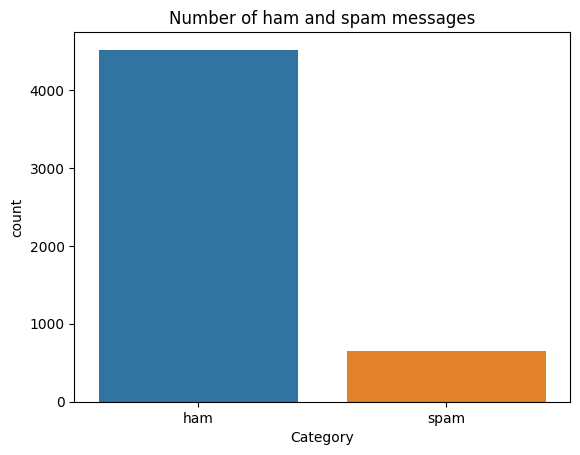

In [12]:
#plot the ham and spam messages to understand the distribution
sns.countplot(data=df, x=df.Category)
plt.xlabel('Category')
plt.title('Number of ham and spam messages')

<AxesSubplot: title={'center': 'Category'}>

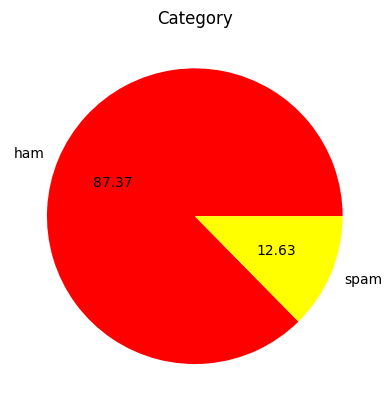

In [13]:
df.groupby('Category').size().plot(kind='pie', autopct='%.2f', colors=['red', 'yellow'], title="Category")

We can observe that Ham contains 87.37% while spam constitute only 12.63% of the total dataset

# Text Preprocessing

In [14]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [15]:
# Initialize stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Define function to preprocess text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = "".join([char for char in text if char not in string.punctuation])
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = " ".join([word for word in text.split() if word not in stop_words])
    # Tokenize
    tokens = nltk.word_tokenize(text)
    # Stem and lemmatize
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    stemmed_tokens = [stemmer.stem(token) for token in lemmatized_tokens]
    # Join tokens back into text string
    preprocessed_text = " ".join(stemmed_tokens)
    return preprocessed_text

# Apply preprocessing function to 'Message' column
df['Message'] = df['Message'].apply(preprocess_text)

In [16]:
df.head()

,Category,Message
0,ham,go jurong point crazi avail bugi n great world...
1,ham,ok lar joke wif u oni
2,spam,free entri 2 wkli comp win fa cup final tkt 21...
3,ham,u dun say earli hor u c alreadi say
4,ham,nah dont think go usf life around though


# Creating a model that fits the data

### Encode the Target Variable

In [17]:
# Label Encode The Target Variable
encode = LabelEncoder()
df.Category = encode.fit_transform(df.Category)

In [18]:
df.head()

,Category,Message
0,0,go jurong point crazi avail bugi n great world...
1,0,ok lar joke wif u oni
2,1,free entri 2 wkli comp win fa cup final tkt 21...
3,0,u dun say earli hor u c alreadi say
4,0,nah dont think go usf life around though


In [19]:
x_train, x_test, y_train, y_test = train_test_split(df['Message'], df["Category"], test_size = 0.2, random_state = 0)

### Feature Extraction using BoW feature

In [20]:
# Generate the bag-of-words features
vectorizer = CountVectorizer()
x_train = vectorizer.fit_transform(x_train)
x_test = vectorizer.transform(x_test)

In [21]:
# store the vectorizer object in a separate pickle file
pickle.dump(vectorizer, open('count_vectorizer.pkl', 'wb'))

### Logistic Regression Model

In [22]:
LR = LogisticRegression()
LR.fit(x_train,y_train)
predict = LR.predict(x_test)
print(classification_report(y_test, predict))
LRAcc = accuracy_score(predict,y_test)
print('Logistic Regression accuracy is: {:.2f}%'.format(LRAcc*100))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       885
           1       0.99      0.86      0.92       149

    accuracy                           0.98      1034
   macro avg       0.98      0.93      0.95      1034
weighted avg       0.98      0.98      0.98      1034

Logistic Regression accuracy is: 97.87%


#### Confusion Matrix for Logistic Regression

Confusion Matrix for Logistic Regression :
 [[884   1]
 [ 21 128]] 



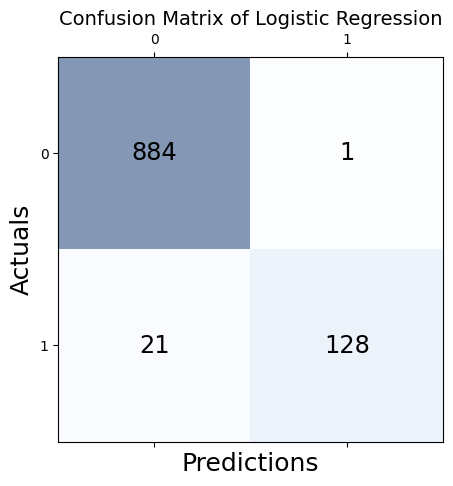

In [23]:
# Confusion Matrix for Logistic Regression  
cm = metrics.confusion_matrix(y_test, predict)
print('Confusion Matrix for Logistic Regression :\n', cm, '\n')
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.5)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix of Logistic Regression', fontsize=14)
plt.show()

### SVC Model

In [24]:
svc = SVC(kernel="linear")
svc.fit(x_train,y_train)
predict_svc = svc.predict(x_test)
print(classification_report(y_test, predict_svc))
SVCAcc = accuracy_score(predict_svc,y_test)
print('SVC model accuracy is: {:.2f}%'.format(SVCAcc*100))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       885
           1       0.96      0.87      0.91       149

    accuracy                           0.98      1034
   macro avg       0.97      0.93      0.95      1034
weighted avg       0.98      0.98      0.98      1034

SVC model accuracy is: 97.58%


#### Confusion Matrix for SVC Model

Confusion Matrix for SVC :
 [[880   5]
 [ 20 129]] 



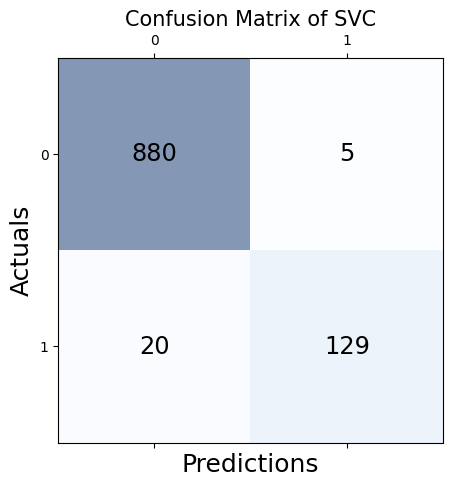

In [25]:
cm = metrics.confusion_matrix(y_test, predict_svc)
print('Confusion Matrix for SVC :\n', cm, '\n')
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.5)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix of SVC', fontsize=15)
plt.show()

### ID3 Model

In [26]:
DT = DecisionTreeClassifier(max_depth=(1), random_state=0)
DT.fit(x_train,y_train)
predict_ID3 = DT.predict(x_test)
print(classification_report(y_test, predict_ID3))
ID3Acc = accuracy_score(predict_svc,y_test)
print('ID3 model accuracy is: {:.2f}%'.format(ID3Acc*100))

              precision    recall  f1-score   support

           0       0.91      0.96      0.93       885
           1       0.62      0.40      0.49       149

    accuracy                           0.88      1034
   macro avg       0.77      0.68      0.71      1034
weighted avg       0.86      0.88      0.87      1034

ID3 model accuracy is: 97.58%


#### Confusion Matrix for ID3 Model

Confusion Matrix for ID3 :
 [[849  36]
 [ 89  60]] 



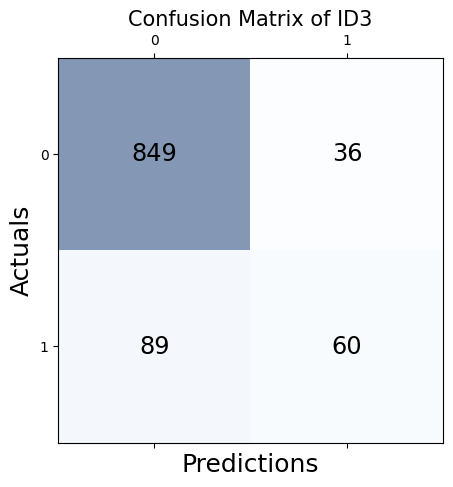

In [27]:
cm = metrics.confusion_matrix(y_test, predict_ID3)
print('Confusion Matrix for ID3 :\n', cm, '\n')
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.5)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix of ID3', fontsize=15)
plt.show()


### Random Forest Model

In [28]:
clf=RandomForestClassifier(n_estimators=100)
clf.fit(x_train,y_train)
y_pred_rf = clf.predict(x_test)
print(classification_report(y_test, y_pred_rf))
rfAcc = accuracy_score(y_pred_rf,y_test)
print('Random Forest model accuracy is: {:.2f}%'.format(rfAcc*100))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       885
           1       1.00      0.77      0.87       149

    accuracy                           0.97      1034
   macro avg       0.98      0.89      0.93      1034
weighted avg       0.97      0.97      0.97      1034

Random Forest model accuracy is: 96.71%


#### Confusion Matrix for Random Forest

Confusion Matrix for Random Forest :
 [[885   0]
 [ 34 115]] 



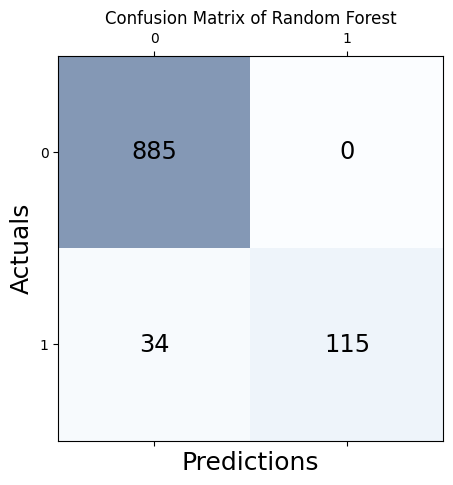

In [29]:
cm = metrics.confusion_matrix(y_test, y_pred_rf)
print('Confusion Matrix for Random Forest :\n', cm, '\n')
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.5)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix of Random Forest', fontsize=12)
plt.show()

### Multinomial Naive Bayes Model

In [30]:
# Train a Naive Bayes classifier
nb = MultinomialNB()
nb.fit(x_train, y_train)
y_pred_naive = nb.predict(x_test)
print(classification_report(y_test, y_pred_naive))
naiveAcc = accuracy_score(y_pred_naive,y_test)
print('Naive Bayes model accuracy is: {:.2f}%'.format(naiveAcc*100))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       885
           1       0.97      0.87      0.92       149

    accuracy                           0.98      1034
   macro avg       0.97      0.93      0.95      1034
weighted avg       0.98      0.98      0.98      1034

Naive Bayes model accuracy is: 97.78%


#### Confusion Matrix for Multinomial Naive Bayes Model

Confusion Matrix for Random Forest :
 [[881   4]
 [ 19 130]] 



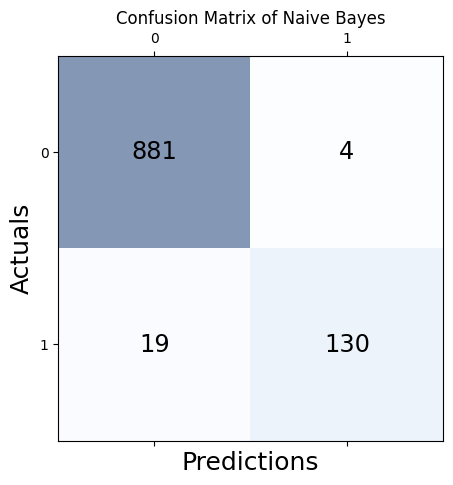

In [31]:
cm = metrics.confusion_matrix(y_test, y_pred_naive)
print('Confusion Matrix for Random Forest :\n', cm, '\n')
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.5)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix of Naive Bayes', fontsize=12)
plt.show()

## Load the Multinomial Naive Bayes Model

In [32]:
joblib_file = "model_NB"
joblib.dump(nb, joblib_file)
loaded_model = joblib.load(open(joblib_file, 'rb'))
pred_y = loaded_model.predict(x_test)
result = np.round(accuracy_score(y_test, pred_y), 2)
print(result)

0.98
